# Прогнозирование прибыльности добычи нефти в регионах

**Описание исследования**  

Добывающей компании «ГлавРосГосНефть» необходимо решить, где бурить новую скважину. Компания предоставила пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

**Цель исследования**
- Предсказать объем запасов в новых скважинах
- Опеределить регион с максимальной суммарной прибылью отобранных скважин

**Ход исследования**
- Обзор данных
- Предобработка данных
- Разбиение на тренировочную и валидационную выборки
- Обучение моделей
- Расчет прибыли и оценка рисков
- Общий вывод

## Импорт необходимых библиотек

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import six


from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import uniform, randint

from numpy.random import RandomState
from scipy import stats as st

## Загрузка данных

Поскольку числительные в названиях переменных - не хорошо, наши три региона будут называться alpha, bravo и charlie

In [14]:
# Регион 1

try:
    df_alpha = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_7_machine_learning_in_business\data\geo_data_0.csv"
    )
except:
    df_alpha = pd.read_csv("/datasets/geo_data_0.csv")

In [15]:
# Регион 2

try:
    df_bravo = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_7_machine_learning_in_business\data\geo_data_1.csv"
    )
except:
    df_bravo = pd.read_csv("/datasets/geo_data_1.csv")

In [16]:
# Регион 3

try:
    df_charlie = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_7_machine_learning_in_business\data\geo_data_2.csv"
    )
except:
    df_charlie = pd.read_csv("/datasets/geo_data_2.csv")

## Обзор данных

In [17]:
df_list = [df_alpha, df_bravo, df_charlie]

**Посмотрим размеры датасетов**

In [18]:
for df in df_list:
    display(df.shape)

(100000, 5)

(100000, 5)

(100000, 5)

**Выведем общую информацию**

In [19]:
for df in df_list:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

С типами данных все хорошо, пропусков в датасетах нет. 

**Посмотрим как выглядят данные**

In [20]:
for df in df_list:
    display(df.sample(3))

,id,f0,f1,f2,product
76095,6bita,-1.006913,0.234769,-1.488237,97.758309
88276,zXziG,-1.038679,0.011715,1.171847,7.745288
86234,rF04X,-0.817806,0.680403,-1.321952,99.168484


,id,f0,f1,f2,product
1714,C4E9S,0.238725,-0.552280,-0.000071,3.179103
29767,tDZyI,9.290374,-7.334780,3.997688,107.813044
40368,c0mBf,-3.376110,-8.685217,5.008846,137.945408


,id,f0,f1,f2,product
51592,aqoEl,1.414615,2.039827,4.702283,109.296930
77507,8T1Hv,0.315943,0.770514,4.644412,118.052017
50876,uDicB,1.926474,-0.010265,7.955366,120.854788


**Проверим на явные и неявные дубликаты**

В датасетах с id объектов удобно проверять наличие неявных дубликатов: если дублей в столбце id нет, то и в целом их быть не должно

In [21]:
for df in df_list:
    display(df["id"].duplicated(keep=False).sum())

20

8

8

In [22]:
for df in df_list:
    display(df[df["id"].duplicated(keep=False) == True])

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Фиксируется явное присутствие неявных дубликатов. id объектов совпадает, однако, все остальные данные различаются. У разных скважин не может быть одного id. К сожалению, что стоит за признаками мы не знаем, поэтому понять причину дублирования id затруднительно. Можно выдвинуть предположение, что в ПО бурильного оборудования, собирающего данные по скважинам, имеется баг, в результате которого в редких случаях две скважины получают один и тот же id. В любом случае, в обучении моделей id никак применяться не будет, и поскольку в каждом из датасетов таких дублей немного, их можно оставить. Хотя если бы задача состояла не только в выборе оптимального региона, но и оптимальных скважин в нем - следовало бы удалить все скважины с дублированными id. 

**Корреляция признаков и целевого показателя**

In [23]:
for df in df_list:
    display(df.corr(numeric_only=True))

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Очень сильная корреляция между `f2` и `product` в регионе bravo.

**Гистограммы**

In [24]:
num_col = ["f0", "f1", "f2", "product"]

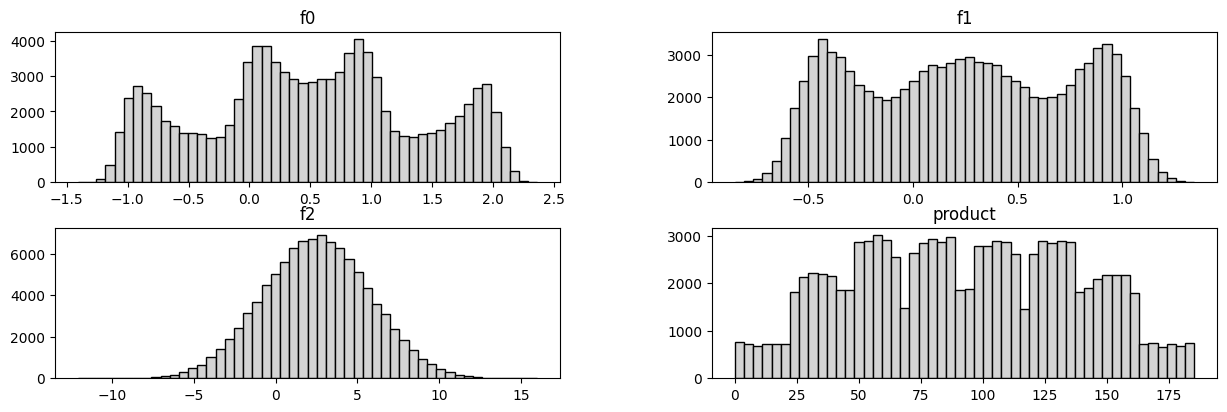

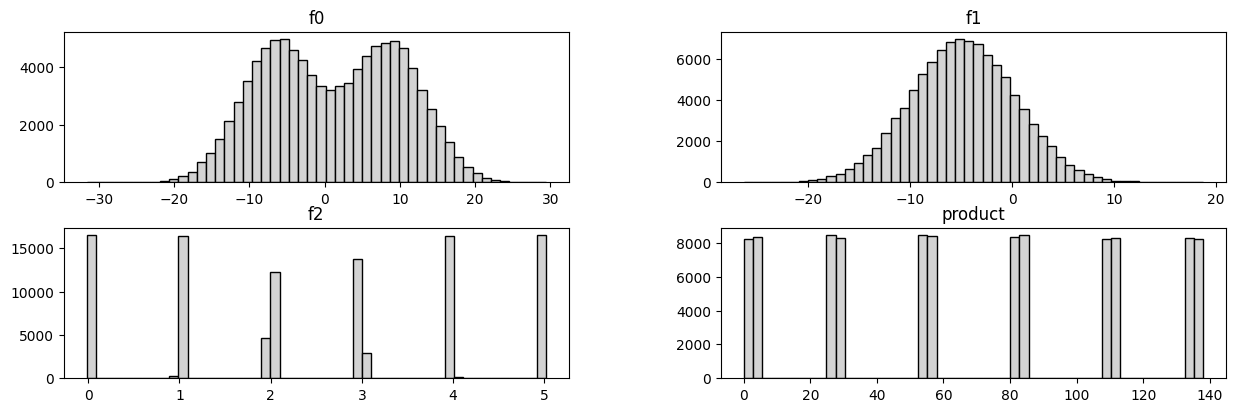

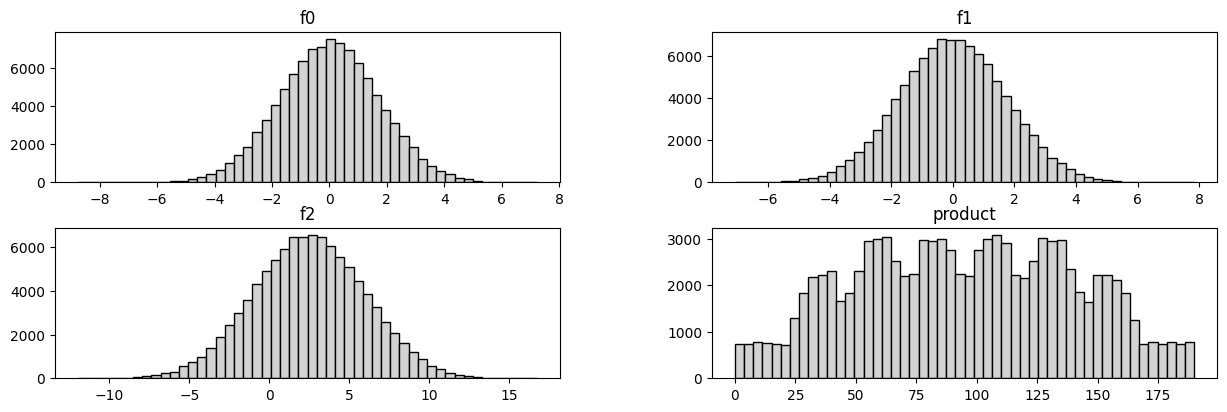

In [25]:
for i, df in enumerate(df_list):
    df[num_col].hist(
        bins=50, figsize=(15, 4.5), edgecolor="black", color="lightgrey", grid=False
    )

Довольно занятно, что в регионе bravo значения столбцов `f2` и `product` дают дискретные линии в диапазонах некоторых значений. В регионах alpha(`f1`, `f2`) и bravo (`f0`) указанные параметры имеют весьма странные бимодальные (в случае региона alpha скорее даже три- или квадмодальные) распределения. Данные синтетические, поэтому особого смысла искать корни таких распределений нет. 

**На всякий случай взглянем на боксплоты колонки `product`**

Нижняя граница в регионе alpha равна -51.60236680760907
Верхняя граница в регионе alpha равна 236.66396243896986
Нижняя граница в регионе bravo равна -94.33641361038892
Верхняя граница в регионе bravo равна 229.10271876808736
Нижняя граница в регионе charlie равна -47.26643772727831
Верхняя граница в регионе charlie равна 237.31190538130107


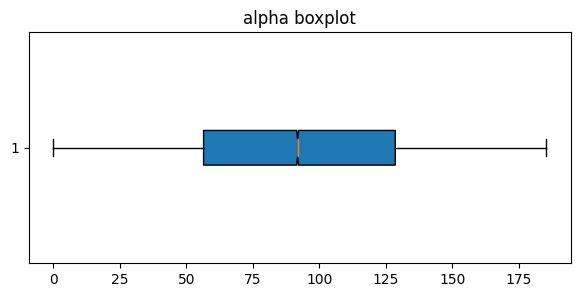

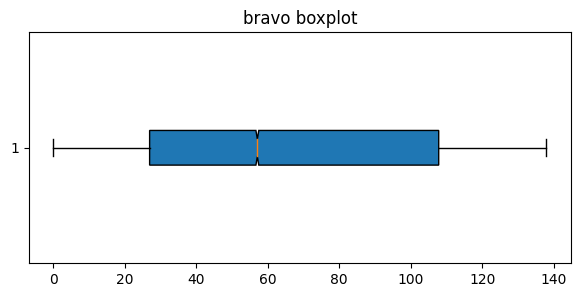

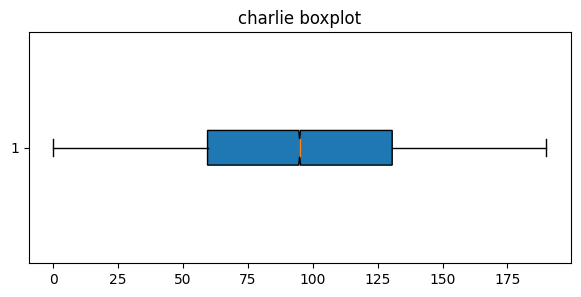

In [26]:
rg_names = ["alpha", "bravo", "charlie"]
for i, df in enumerate(df_list):
    plt.figure(figsize=(7, 3))
    plt.boxplot(
        x=df["product"],
        notch=True,
        vert=False,
        patch_artist=True,
    )
    plt.title(f"{rg_names[i]} boxplot")
    Q1 = df["product"].quantile(0.25)
    Q3 = df["product"].quantile(0.75)
    IQR = Q3 - Q1
    left_border = Q1 - 1.5 * IQR
    right_border = Q3 + 1.5 * IQR
    print(f"Нижняя граница в регионе {rg_names[i]} равна {left_border}")
    print(f"Верхняя граница в регионе {rg_names[i]} равна {right_border}")

## Предобработка данных

Единственное, что необходимо сделать с текущими датафреймами, это убрать колонку `id`. 

In [27]:
df_alpha.drop(columns="id", inplace=True)
df_bravo.drop(columns="id", inplace=True)
df_charlie.drop(columns="id", inplace=True)
df_alpha.shape, df_bravo.shape, df_charlie.shape

((100000, 4), (100000, 4), (100000, 4))

## Разбиение на выборки

In [28]:
X_alpha = df_alpha.drop(columns="product")
X_bravo = df_bravo.drop(columns="product")
X_charlie = df_charlie.drop(columns="product")

y_alpha = df_alpha["product"]
y_bravo = df_bravo["product"]
y_charlie = df_charlie["product"]

In [29]:
chosen_rs = 31121600

In [30]:
X_alpha_train, X_alpha_valid, y_alpha_train, y_alpha_valid = train_test_split(
    X_alpha, y_alpha, test_size=0.25, random_state=chosen_rs
)
X_alpha_train.shape, y_alpha_train.shape, X_alpha_valid.shape, y_alpha_valid.shape

((75000, 3), (75000,), (25000, 3), (25000,))

In [31]:
X_bravo_train, X_bravo_valid, y_bravo_train, y_bravo_valid = train_test_split(
    X_bravo, y_bravo, test_size=0.25, random_state=chosen_rs
)
X_bravo_train.shape, y_bravo_train.shape, X_bravo_valid.shape, y_bravo_valid.shape

((75000, 3), (75000,), (25000, 3), (25000,))

In [32]:
X_charlie_train, X_charlie_valid, y_charlie_train, y_charlie_valid = train_test_split(
    X_charlie, y_charlie, test_size=0.25, random_state=chosen_rs
)
X_charlie_train.shape, y_charlie_train.shape, X_charlie_valid.shape, y_charlie_valid.shape

((75000, 3), (75000,), (25000, 3), (25000,))

## Обучение моделей

In [33]:
data_list_alpha = [X_alpha_train, y_alpha_train, X_alpha_valid, y_alpha_valid]
data_list_bravo = [X_bravo_train, y_bravo_train, X_bravo_valid, y_bravo_valid]
data_list_charlie = [X_charlie_train, y_charlie_train, X_charlie_valid, y_charlie_valid]

In [34]:
data_list = [data_list_alpha, data_list_bravo, data_list_charlie]

In [35]:
def rmse_score(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [36]:
rg_list = ["alpha", "bravo", "charlie"]

In [37]:
cat_preds = []
cat_reg_params = {
    "iterations": randint(2, 15),
    "depth": randint(2, 15),
    "learning_rate": [1],
    "loss_function": ["RMSE"],
    "verbose": [False],
}
for i, data in enumerate(data_list):
    rs = RandomizedSearchCV(
        CatBoostRegressor(),
        cat_reg_params,
        cv=5,
        # error_score='raise',
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
    )
    rs.fit(data[0], data[1])
    cat_model = rs.best_estimator_
    predictions = cat_model.predict(data[2])
    cat_preds.append(predictions)
    rmse = rmse_score(predictions, data[3])
    print("=" * 79)
    print(
        f"\nСреднее значение объемов запасов в скважине региона {rg_list[i]}: {predictions.mean():.3f}"
    )
    print(f"\nRMSE = {rmse:.3f}\n")
    print("=" * 79)


Среднее значение объемов запасов в скважине региона alpha: 92.405

RMSE = 37.334


Среднее значение объемов запасов в скважине региона bravo: 68.953

RMSE = 1.888


Среднее значение объемов запасов в скважине региона charlie: 95.075

RMSE = 37.664



In [38]:
lr_preds = []
lr_param_grid = {}
for i, data in enumerate(data_list):
    rs = RandomizedSearchCV(
        LinearRegression(),
        lr_param_grid,
        n_iter=1,
        cv=5,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
    )
    rs.fit(data[0], data[1])
    lr_model = rs.best_estimator_
    predictions = lr_model.predict(data[2])
    lr_preds.append(predictions)
    rmse = rmse_score(predictions, data[3])
    print("=" * 79)
    print(
        f"\nСреднее значение объемов запасов в скважине региона {rg_list[i]}: {predictions.mean():.3f}"
    )
    print(f"\nRMSE = {rmse:.3f}\n")
    print("=" * 79)


Среднее значение объемов запасов в скважине региона alpha: 92.404

RMSE = 37.787


Среднее значение объемов запасов в скважине региона bravo: 68.948

RMSE = 0.888


Среднее значение объемов запасов в скважине региона charlie: 95.049

RMSE = 40.069



**Вывод:** в случае регионов alpha и charlie показатель RMSE крайне ощутим, при этом в регионе bravo он кратно меньше. Скорее всего это связано с дискретностью значений в столбцах `f2` и `product` в случае региона bravo, которая помогает модели в предсказании. 

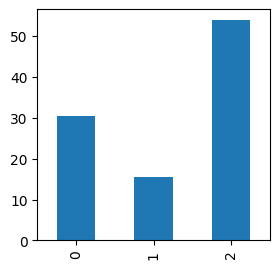

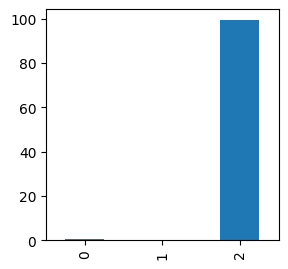

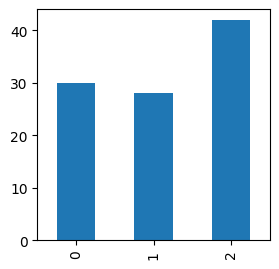

In [39]:
for data in data_list:
    md = CatBoostRegressor(iterations=10, depth=10, verbose=False)
    md.fit(data[0], data[1])
    cat_importances = md.feature_importances_
    pd.Series(cat_importances).plot(kind="bar", figsize=(3, 3))
    plt.show()

**Вывод 2:** действительно, в случае региона bravo признаки f0 и f1 вообще не используются.

## Подготовка к расчету прибыли

In [40]:
BUDGET = 10**10

In [41]:
PRICE_PER_UNIT = 450_000

In [42]:
sufficient_volume_per_rg = np.ceil(BUDGET / PRICE_PER_UNIT)
sufficient_volume_per_well = np.ceil(BUDGET / PRICE_PER_UNIT) / 200
sufficient_volume_per_rg, sufficient_volume_per_well

(22223.0, 111.115)

По условию задания, при разведке региона роется 500 скважин. Выберем из предсказанных списков по 500 скважин в каждом регионе. 

In [43]:
wells_volume_alpha = pd.Series(lr_preds[0], index=y_alpha_valid.index).sample(
    frac=0.02, replace=True, random_state=chosen_rs
)
wells_volume_bravo = pd.Series(lr_preds[1], index=y_bravo_valid.index).sample(
    frac=0.02, replace=True, random_state=chosen_rs
)
wells_volume_charlie = pd.Series(lr_preds[2], index=y_charlie_valid.index).sample(
    frac=0.02, replace=True, random_state=chosen_rs
)

In [44]:
wells_volumes = [wells_volume_alpha, wells_volume_bravo, wells_volume_charlie]

Посмотрим на средний объем скважин в регионах

In [45]:
wells_volume_alpha.mean(), wells_volume_bravo.mean(), wells_volume_charlie.mean()

(94.11407407696913, 66.77793733752065, 96.00645311979457)

**Вывод** средние значения по региону меньше объема, необходимого для безубыточной добычи

## Расчет прибыли

In [46]:
def best_two_fifths(volumes_list, target):
    temp = volumes_list.sort_values(ascending=False)
    temp_best = temp.iloc[range(0, 200)]
    return target[temp_best.index]

In [47]:
targets = [y_alpha_valid, y_bravo_valid, y_charlie_valid]

In [48]:
rg_revenue_list = []
for i, rg_volumes in enumerate(wells_volumes):
    best = best_two_fifths(rg_volumes, targets[i])
    overall_rg_volume = best.sum()
    rg_revenue = (overall_rg_volume * PRICE_PER_UNIT - BUDGET) / 10**9
    rg_revenue_list.append(rg_revenue)
    print(
        f"Регион {rg_list[i]} потенциально может принести {rg_revenue:.3f} млрд рублей прибыли при общих запасах {overall_rg_volume:.3f} тыс. баррелей."
    )

Регион alpha потенциально может принести 0.436 млрд рублей прибыли при общих запасах 23190.726 тыс. баррелей.
Регион bravo потенциально может принести 0.107 млрд рублей прибыли при общих запасах 22459.392 тыс. баррелей.
Регион charlie потенциально может принести 0.497 млрд рублей прибыли при общих запасах 23327.130 тыс. баррелей.


**Вывод**: потенциальные показатели прибыли во всех трех регионах выше порогового значения. 

## Расчет рисков 

Средняя выручка региона alpha: 0.61 млрд рублей.
95% доверительный интервал: (0.5867374205661469, 0.6275867325196045)
Вероятность убытков: 3.0 %

Средняя выручка региона bravo: 0.66 млрд рублей.
95% доверительный интервал: (0.6404000636093228, 0.6737155351358057)
Вероятность убытков: 0.3 %

Средняя выручка региона charlie: 0.58 млрд рублей.
95% доверительный интервал: (0.555664663833999, 0.5949753350330294)
Вероятность убытков: 3.3 %



Text(0, 0.5, 'Число выборок bootstrap, шт')

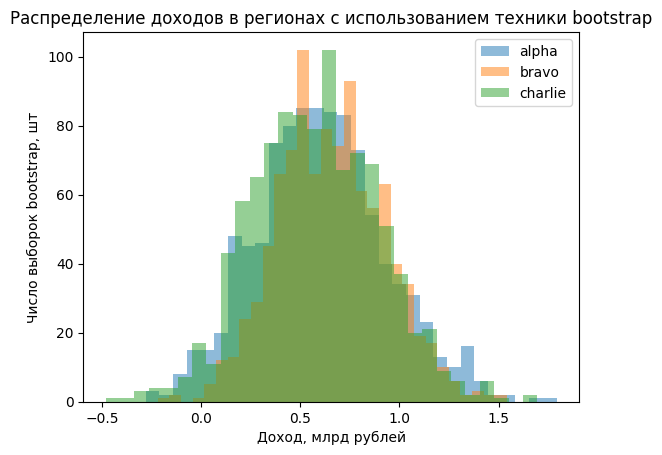

In [49]:
state = RandomState(chosen_rs)
targets = [y_alpha_valid, y_bravo_valid, y_charlie_valid]
rg_mean_revenue = []
for i, target in enumerate(targets):
    revenue_values = []
    target = target
    preds = pd.Series(lr_preds[i], index=y_alpha_valid.index)
    for j in range(1000):
        target_subsample = target.sample(frac=0.02, replace=True, random_state=state)
        preds_subsample = preds[target_subsample.index]
        res = (
            (best_two_fifths(preds_subsample, target_subsample).sum()) * PRICE_PER_UNIT
            - BUDGET
        ) / 10**9
        revenue_values.append(res)

    revenue_values = pd.Series(revenue_values)
    plt.hist(revenue_values, bins=30, alpha=0.5)

    mean = revenue_values.mean()
    rg_mean_revenue.append(mean)

    confidence_interval = st.t.interval(
        0.95,
        df=len(revenue_values) - 1,
        loc=revenue_values.mean(),
        scale=revenue_values.sem(),
    )

    loss_probs = revenue_values[revenue_values < 0].count() / revenue_values.count()

    # T-test для отсеивания регионов, в которых вероятность убытков выше 2.5%
    # H0 - доход с региона не превысит 10 млрд, H1 - доход с региона превысит 10 млрд

    # alpha_stat = .05
    # revenue_threshold = 10

    # pvalue = st.ttest_1samp(revenue_values, revenue_threshold).pvalue / 2
    # print(pvalue)

    # if pvalue < alpha_stat:
    print(f"Средняя выручка региона {rg_list[i]}: {mean:.2f} млрд рублей.")
    print(f"95% доверительный интервал: {confidence_interval}")
    # print(f'Вероятность убытков меньше 2.5%\n')
    print(f"Вероятность убытков: {loss_probs*100:.1f} %\n")
    # else:
    # print(f'В регионе {rg_list[i]} вероятность убытков выше 2.5%')

plt.title("Распределение доходов в регионах с использованием техники bootstrap")
plt.legend(["alpha", "bravo", "charlie"])
plt.xlabel("Доход, млрд рублей")
plt.ylabel("Число выборок bootstrap, шт")

**Вывод:**  лишь один регоин - bravo - прошел проверку на риск убытков, поэтому к разработке предлагается именно он.

## Общий вывод

В ходе проведенного исследования были построены модели прогнозирования объемов сырья в нефтяных скважинах. На основе спрогнозированных данных по трем регионам были расчитаны показатели потенциальной выручки в каждом регионе, расчитана вероятность убытков. На основе проведенных расчетов из трех регионов - alpha, bravo и charlie - предложено выбрать регион bravo, поскольку в оставшихся регионах шанс убытков превышает 2.5%.